In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pickle
import scipy
import time 
from tqdm import tqdm

import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel

from delfi.distribution.mixture import MoG
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 18,
              'legend.frameon': False,
                      'axes.titlesize': 21,
                      'axes.labelsize': 19,
                      'xtick.labelsize': 15,
                      'ytick.labelsize': 15,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

## Bayesian model comparison with difficult Poisson vs. NB 

In the master thesis the model posterior MDN tended to predict extreme values for the posterior. We are not sure whether this is due to overfitting or because the comparison problem was just too simple. 

Here, we want to set up the Poisson vs. NB comparison such that it becomes arbitrarily difficult, e.g., such that the NB equals the Poisson model. 

To this end we have to tune the priors such that the NB approaches the Poisson distribution. According to Wikipedia, this happens for small $p$ and large $r$. 

https://en.wikipedia.org/wiki/Negative_binomial_distribution#Overdispersed_Poisson

The priors are 
\begin{align}
\lambda &\sim Gamma(k_1, \theta_1) \\
r = k &\sim Gamma(k_2, \theta_2) \\
\frac{p}{1-p} = \theta &\sim Gamma(k_3, \theta_3)
\end{align}

We want $r$ to be large and $p$ to be small. Therefore, we should choose the prior for $r$ and $p$ accordingly. 

## Set up models

In [3]:
sample_size = 5
ntrain = 10000
ntest = 100

# prior for r 
k2 = 10.
theta2 = 2.0

# prior for theta / p 
k3 = 0.5
theta3 = 1. 

# then the scale of the Gamma prior for the Poisson is given by
theta1 = 2.0
k1 = (k2 * theta2 * k3 * theta3) / theta1
print(k1)

m0 = PoissonModel(sample_size=sample_size, n_workers=2)
m1 = NegativeBinomialModel(sample_size=sample_size, n_workers=2)

# set the priors 
prior0 = scipy.stats.gamma(a=k1, scale=theta1)
prior11 = scipy.stats.gamma(a=k2, scale=theta2)
prior12 = scipy.stats.gamma(a=k3, scale=theta3)

5.0


In [4]:
n = ntrain + ntest
params_m0 = prior0.rvs(size=int(n / 2))
params_m1 = np.vstack((prior11.rvs(size=int(n / 2)), 
                       prior12.rvs(size=int(n / 2)))).T

## Generate parameters from the priors 

## Generate data from models and calculate summary stats, prepare test data 

In [5]:
data_m0 = m0.gen(params_m0)
data_m1 = m1.gen(params_m1)

In [6]:
# shuffle and set up model index target vector 
x_all = np.vstack((data_m0, data_m1))

# define model indices
m_all = np.hstack((np.zeros(data_m0.shape[0]), np.ones(data_m1.shape[0]))).squeeze().astype(int)

# get shuffled indices 
shuffle_indices = np.arange(n)
np.random.shuffle(shuffle_indices)

# shuffle the data 
x_all = x_all[shuffle_indices, ]
m_all = m_all[shuffle_indices].tolist()

x, xtest = x_all[:ntrain, :], x_all[ntrain:, :]
m, mtest = m_all[:ntrain], m_all[ntrain:]

# calculate summary stats
sx = calculate_stats_toy_examples(x)
sx_test = calculate_stats_toy_examples(xtest)
# use training norm to normalize test data 
sx_zt, training_norm = normalize(sx)
sx_test_zt, training_norm = normalize(sx_test, training_norm)

## Set up the NN and train it 

training: 100%|██████████| 100/100 [00:07<00:00, 15.85it/s]


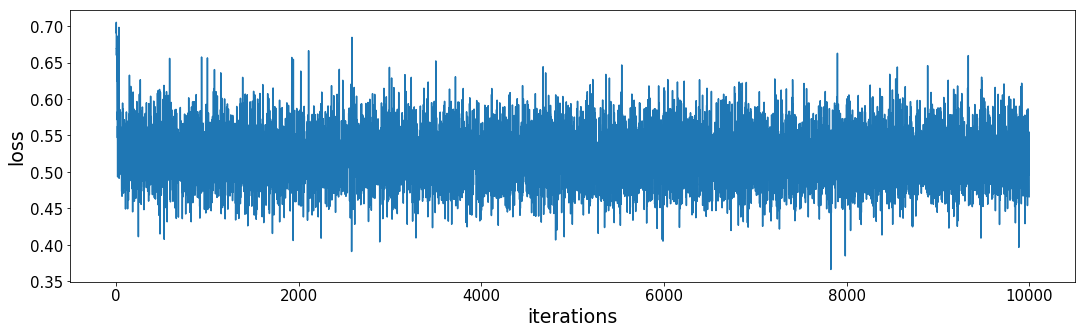

In [7]:
model = ClassificationMDN(n_input=2, n_hidden_units=10, n_hidden_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = Trainer(model, optimizer, verbose=True, classification=True)

n_epochs = 100 
n_minibatch = int(ntrain / 100)

# train with training data
loss_trace = trainer.train(sx_zt, m, n_epochs=n_epochs, n_minibatch=n_minibatch)
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

### Visualize the NN input output function

In [8]:
ppoi_exact = []
with tqdm.tqdm(total=len(mtest), desc='Calculate evidences for test samples', ncols=110) as pbar: 
    for xi in xtest: 
        nb_logevi = calculate_nb_evidence(xi, k2, theta2, k3, theta3, log=True)
        poi_logevi = poisson_evidence(xi, k=k1, theta=theta1, log=True)
        ppoi_exact.append(calculate_pprob_from_evidences(np.exp(poi_logevi), np.exp(nb_logevi)))
        pbar.update()

Calculate evidences for test samples:  92%|███████████████████████████████▎  | 92/100 [03:29<00:15,  1.97s/it]../../model_comparison/utils.py:662: RuntimeWarning: divide by zero encountered in log
  value = np.log(nbinom_pmf(x, r, p)).sum() + np.log(pr) + np.log(pp)
Calculate evidences for test samples: 100%|█████████████████████████████████| 100/100 [03:49<00:00,  2.01s/it]


In [9]:
ms, vs = np.meshgrid(np.linspace(0, 50, 100), np.linspace(0, 50, 100))
# stack values to evaluate as vector in the model 
sx_vis = np.vstack((ms.flatten(), vs.flatten())).T
# normalize 
sx_vis, training_norm = normalize(sx_vis, training_norm)


# predict probs 
ppoi_vec = model.predict(sx_vis)
# take poisson posterior prob and reshape to grid dimensions
ppoi_vismat = ppoi_vec[:, 0].reshape(ms.shape[0], vs.shape[0])

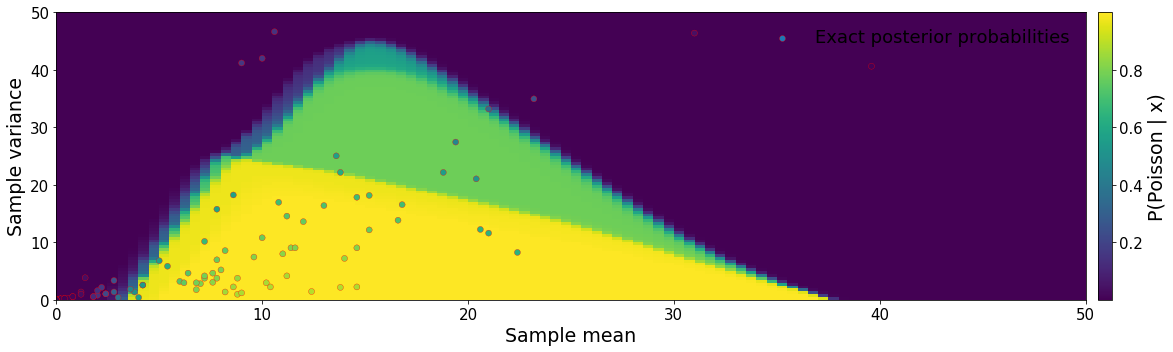

In [10]:
plt.figure(figsize=(18, 5))
cnorm = mpl.colors.Normalize(vmin=ppoi_vismat.min(), vmax=ppoi_vismat.max())
cmap = plt.cm.viridis

plt.scatter(x=sx_test[:, 0], y=sx_test[:, 1], c=np.array(ppoi_exact), cmap=cmap, 
            norm=cnorm, edgecolors='r', linewidths=0.3)
plt.imshow(ppoi_vismat, origin='lower', aspect='auto', 
           norm=cnorm, cmap=cmap, extent=[ms.min(), ms.max(), vs.min(), vs.max()])

plt.xlabel('Sample mean')
plt.ylabel('Sample variance')
plt.colorbar(label='P(Poisson | x)', pad=0.01)
plt.legend(['Exact posterior probabilities'])
plt.tight_layout();

Text(0.5, 1.0, 'distribution of predicted posterior probabilities')

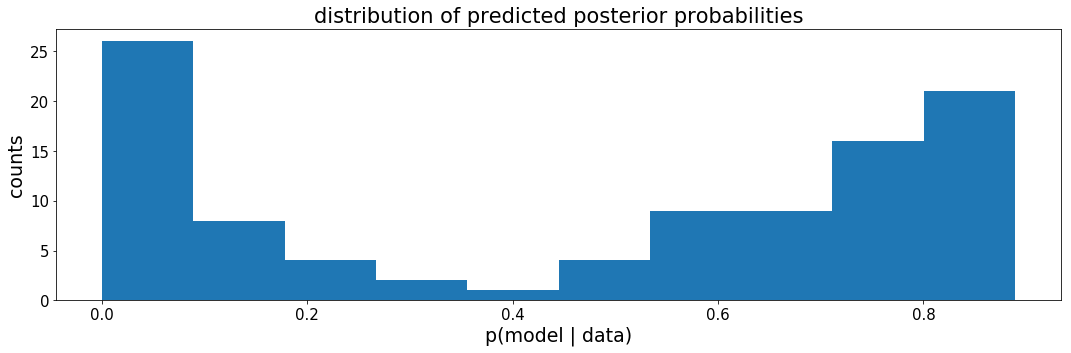

In [11]:
plt.hist(ppoi_exact)
plt.ylabel('counts')
plt.xlabel('p(model | data)')
plt.title('distribution of predicted posterior probabilities')